# Objective
Goal here is to apply NLP to perform analysis on the published financial reports, more specifically on the annual 10-K filings(and later 10-Q i.e quaterly filings) for the listed companies.

## What are 10-K filings?
A 10-K is a comprehensive report filed annually by a publicly-traded company about its financial performance and is required by the U.S. Securities and Exchange Commission (SEC).  
Source: [Investopedia](https://www.investopedia.com/terms/1/10-k.asp) 

## Where can one get 10-K filings in a machine readable format?
10-K filings are available on sec website and can be easily searched via their tool [EDGAR](https://www.sec.gov/edgar/searchedgar/companysearch.html). EDGAR is the Electronic Data Gathering, Analysis, and Retrieval system used at the U.S. Securities and Exchange Commission (SEC). These are can be also accessed via their apis as will be done below.

## Which sections of 10-K filings will be used in analyis?
The details of different sections of 10-K filings can be found [here](https://www.sec.gov/fast-answers/answersreada10khtm.html).
The sections that will be used for analysis are:
- Item 1A - “Risk Factors” 
- Item 3 - “Legal Proceedings”
- Item 7 - “Management’s Discussion and Analysis of Financial Condition and Results of Operations”

## Exactly what NLP analysis will be done here?
- Topic Modelling
- Higlighting Trends
- TBC

## Which libraries are going to be used for NLP analysis
- [Spacy](https://spacy.io/)
- [Gensim](https://radimrehurek.com/gensim/)
- BeautifulSoup and other python libraries

## Inspiration
I learnt about EDGAR during my Udacity course `AI for Trading`. I highly recommend this course for the large practical knowldge the course provided. In the course sentiment analysis was performed on 10-K statements and then further used to create factors into a model.

### Install Packages
[installing-python-packages-from-jupyter](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/)

In [1]:
import sys
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from ratelimit import limits, sleep_and_retry
import pandas as pd
import re
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

In [ ]:
!{sys.executable} -m pip install -r requirements.txt

In [ ]:
# download the spacy model

## enable this for downloading & using smaller spacy model
!{sys.executable} -m spacy download en 

## enable this for downloading & using medium spacy model
# !{sys.executable} -m spacy download en_core_web_md

In [2]:
spacy_model = 'en'

# spacy_model = 'en_core_web_md'

In [3]:
# you need cik_map to download form EDGAR
cik_map = {
    'AMZN': '0001018724',
    'AAPL': '0000320193',
    'MSFT': '0000789019',
    'GOOG': '0001652044',
    'GSBD': '0001572694',
    'JPM' : '0000019617'
}

In [4]:
download_dir = Path("./")
tech_firms = ['AMZN', 'AAPL', 'MSFT', 'GOOG']
fin_firms = ['GSBD', 'JPM']
print(tech_firms)
print(cik_map[tech_firms[2]])
print(cik_map['MSFT'])

['AMZN', 'AAPL', 'MSFT', 'GOOG']
0000789019
0000789019


In [5]:
nlp = spacy.load(spacy_model)

In [6]:
additional_stop_words = [] #[u'-PRON-', 'including', 'included', 'gaap']

for stopword in additional_stop_words:
    nlp.vocab[stopword].is_stop = True
for k,v in cik_map.items():
    lexeme = nlp.vocab[k.lower()].is_stop = True

### RequestThrottler
**_This class uses ratelimit to control the requests being sent to the server_**

Decorator `@sleep_and_retry` sleeps and then retries when number of requests are many  
Decorator `@limits defines` the limits


In [7]:
class RequestThrottler(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

req_handler = RequestThrottler()

### get_sec_data
URL: https://www.sec.gov/cgi-bin/browse-edgar retrieves history of filings of a given type (here 10-K) for the company (provided as parameter with cik)    

**Input Parameters:**  
_req_handler:_ Object of RequestThrottler class  
_ticker:_ The ticker of the company whoose 10-K documents are to be fetched  
_doc_type:_ The filing type to be filtered for (default 10-K)  
_max_num:_ The max history of filings in reverse cronological order  

**Output:**  
list of tuple in form [(ticker, filing_date, url_10k_form)]  
where  
_ticker:_ ticker of the company  
_filing_date:_ date of the 10-k form filing  
_url_10k_form:_ url from where the 10-k form can be downloaded for the given year

In [8]:
def get_sec_data(req_handler, ticker, doc_type='10-K', max_num=3):
    start=0
    count=60
    entries=[]
    cik = cik_map.get(ticker,'UNK')
    if cik == 'UNK':
        return entries
    
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    # print(f'rss_url: {rss_url}')
    sec_data = req_handler.get(rss_url)
    feed = BeautifulSoup(sec_data.encode()).feed
    cnt=0
    for entry in feed.find_all('entry', recursive=False):
        if entry.content.find('filing-type').getText() == doc_type and cnt < max_num:
            dt_str = entry.content.find('filing-date').getText()
            entries.append((ticker, 
                            entry.content.find('filing-date').getText()
                            ,entry.content.find('filing-href').getText()
                           ))
            # entries[datetime.strptime(dt_str,'%Y-%m-%d').date()] = entry.content.find('filing-href').getText()
            cnt += 1
    return entries

### download_filings
This function downloads the 10-K form.  

**Input Parameters:**  
Pandas dataframe with the following information:  
_ticker (string):_ The ticker of the company whoose 10-K documents are to be fetched  
_filing_date (string date as YYYY-MM-DD):_ date of the 10-k form filing  
_url_10k_form (string url of 10-k form):_ url from where the 10-k form can be downloaded for the given year

**Output:**  
Path of the downloaded 10-k form as string. `Note: Very large in size`


In [9]:
def download_filings(df_row, req_handler):
    local_path = download_dir / Path(df_row['ticker'] + "_" + df_row['filing_date'] + ".html")
    if local_path.is_file():
        print(f"File Exists {local_path}")
    else:
        print(f"Downloading {df_row['ticker']}, date: {df_row['filing_date']}, url: {df_row['href']}")
        file_url = df_row['href'].replace('-index.htm', '.txt').replace('.txtl', '.txt')
        with open(local_path,'w') as fh:
            # fh.write(get_10K_filings2(raw_fillings_by_ticker))
            fh.write(req_handler.get(file_url))
    return local_path

In [10]:
ticker = 'GOOG'
sec_data = get_sec_data(req_handler, ticker, max_num=5)
# print(sec_data)
df = pd.DataFrame()
df = df.append(sec_data)
df.columns=['ticker','filing_date','href']

#### Download the 10-K form

In [11]:
df['local_html_path'] = df.apply(download_filings, args=(req_handler, ), axis=1)

File Exists GOOG_2020-02-04.html
File Exists GOOG_2019-02-05.html
File Exists GOOG_2018-02-06.html
File Exists GOOG_2017-02-03.html
File Exists GOOG_2016-02-11.html


### Extract the 10-K filing from the 10-K form

This information is extracted by looking for pattern  
`
<DOCUMENT>
<TYPE>10-K
...
...
</DOCUMENT>
`


### get_10K_filing
Extract the documents from the text  

**Input Parameters:**  
text: The text with the `10-K<Document>` inside

**Output:**  
extracted_docs : Plain 10-K text after removing html tags

In [12]:
def get_10K_filing(df_row):
    # local text files already exists
    local_path = download_dir / Path(df_row['ticker'] + "_10K_" + df_row['filing_date'] + ".txt")
    if local_path.is_file():
        print(f"get_10K_filing TEXT Exists: {local_path}")
        with open(local_path, "r") as f:
            contents = f.read()
        return contents
    
    # full 10-K form HTML files exists
    local_path = df_row['local_html_path']
    print(f'get_10K_filing HTML Exists: {local_path}')
    with open(local_path, "r") as f:
        contents = f.read()
    extracted_docs = BeautifulSoup(contents).find_all('document')
    plain_text=""
    for i, doc in enumerate(extracted_docs):
        regex = re.compile(r'.*<type>10-K\s*(\n*.*)</type>', re.DOTALL)
        matches = regex.finditer(str(doc))
        for match in matches:
            # print('match: ', match)
            plain_text = BeautifulSoup(match.group(1), 'html.parser').get_text() # remove all the html
            plain_text = re.sub(r"[\s]+",r" ", plain_text) # remove all blank liness
            plain_text = re.sub(r":",r"_", plain_text) # join words with : with _
            plain_text = plain_text.encode("ascii", "ignore").decode('utf-8') # remove non-ascii
            local_path = download_dir / Path(df_row['ticker'] + "_10K_" + df_row['filing_date'] + ".txt")
            print(f"Writing {local_path}")
            with open(local_path,'w') as fh:
                fh.write(plain_text)        
            return plain_text
    # print(plain_text)
    return plain_text

In [13]:
df['filing'] = df.apply(get_10K_filing, axis=1)

get_10K_filing TEXT Exists: GOOG_10K_2020-02-04.txt
get_10K_filing TEXT Exists: GOOG_10K_2019-02-05.txt
get_10K_filing TEXT Exists: GOOG_10K_2018-02-06.txt
get_10K_filing TEXT Exists: GOOG_10K_2017-02-03.txt
get_10K_filing TEXT Exists: GOOG_10K_2016-02-11.txt


In [ ]:
df

In [14]:
def get_lemmatized_words(df_row):
    print(f"Processing {df_row['ticker']}, date: {df_row['filing_date']}")
    filing_words = []
    doc = nlp(df_row['filing'].lower())
    for word in doc:
        # print(word)
        if word.is_alpha and word.is_ascii and not word.is_stop and word.pos_ != "ADP" and len(word) < 15:
            filing_words.append(word.lemma_)
    return filing_words

In [15]:
df['filing_words'] = df.apply(get_lemmatized_words, axis=1)

Processing GOOG, date: 2020-02-04
Processing GOOG, date: 2019-02-05
Processing GOOG, date: 2018-02-06
Processing GOOG, date: 2017-02-03
Processing GOOG, date: 2016-02-11


In [16]:
bigram = gensim.models.Phrases(df['filing_words'])

In [17]:
df['filing_words_bigrams'] = df['filing_words'].apply(lambda x : bigram[x])

In [18]:
%matplotlib inline
def display_word_cloud(df_row, column_name):
    filing_words = " ".join(df_row[column_name])
    wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(filing_words)
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(str(df_row['ticker'] + "_" + df_row['filing_date']))
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
df.apply(display_word_cloud, args=('filing_words_bigrams', ), axis=1)

In [178]:
docs = df['filing_words_bigrams'].apply(lambda x: " ".join(x)).tolist()

In [168]:
dates = df['filing_date'].tolist()
dates

['2020-02-04', '2019-02-05', '2018-02-06', '2017-02-03', '2016-02-11']

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [159]:
# create the transform
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True, max_df=0.75, min_df=0.1)
# tokenize and build vocab
tfidf_vectorizer.fit(docs)

TfidfVectorizer(max_df=0.75, min_df=0.1)

In [167]:
# summarize
print(len(tfidf_vectorizer.vocabulary_), len(tfidf_vectorizer.idf_))

1330 1330


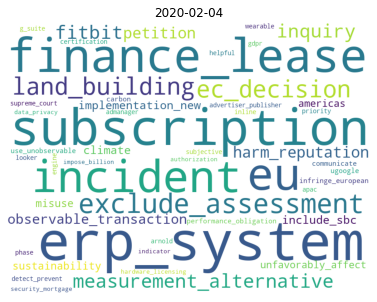

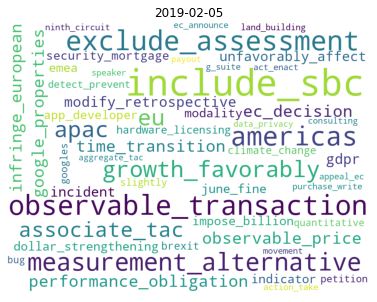

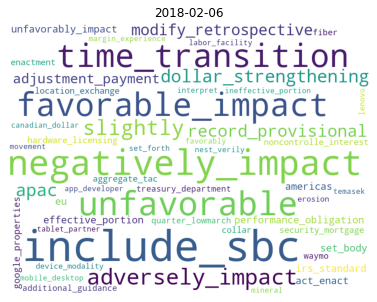

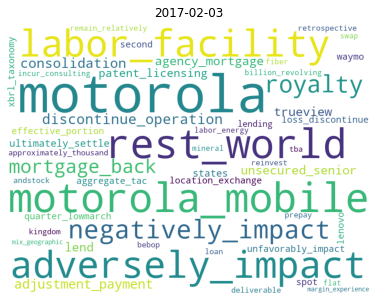

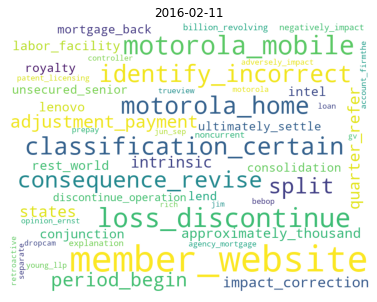

In [174]:
for dt, doc in zip(dates, docs):
    vector = tfidf_vectorizer.transform([doc])
    # summarize encoded vector
    # print(vector.shape)
    # print(vector.toarray())
    df_idf = pd.DataFrame(vector[0].T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
    dict_top50 = df_idf.sort_values(by=['idf_weights'],ascending=False)[:50].to_dict()['idf_weights']
    wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(dict_top50)
    # plot the WordCloud image                        
    plt.imshow(wordcloud)
    plt.title(str(dt))
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [132]:
vector = tfidf_vectorizer.transform(docs)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(5, 1330)
[[0.         0.03829271 0.         ... 0.         0.         0.        ]
 [0.03326287 0.05367255 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.0331961 ]
 [0.         0.         0.         ... 0.056418   0.         0.        ]
 [0.         0.         0.0173964  ... 0.05614124 0.0173964  0.        ]]


In [ ]:
from collections import Counter
def remove_non_important_words(df_row, column_name, custom_exlude_list, max_freq=0.01, min_freq=0.0001):
    print(f"Processing {df_row['ticker']}, date: {df_row['filing_date']}")
    num_words = len(df_row[column_name])
    max_word_count = round(max_freq*num_words)
    min_word_count = round(min_freq*num_words)
    # print(max_word_count, min_word_count)
    counter = Counter(df_row[column_name])
    # word list higher than given frequency or below certain frequency
    non_imp_words = [k for k,v in counter.most_common() if v > max_word_count or v <= min_word_count]
    # remove the non-important (high freq, loq freq)
    filtered_word_list = [w for w in df_row[column_name] if w not in non_imp_words and w not in custom_exlude_list]
    # print(num_words, len(filtered_word_list))
    return filtered_word_list
    

In [ ]:
custom_exlude_list = ['change', 'business', 'google', 'contentsalphabet', 'result', 'company']
df['filtered_words'] = df.apply(remove_non_important_words, args=('filing_words_bigrams', custom_exlude_list, ), axis=1)

In [ ]:
df.apply(display_word_cloud, args=('filtered_words', ), axis=1)

In [ ]:
df['filtered_string'] = df['filtered_words'].apply(lambda x: " ".join(x))


In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog.",
        "The lazy dog",
        "The quick fox"]
# create the transform
vectorizer = TfidfVectorizer(use_idf=True)
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print('get_feature_names: ', vectorizer.get_feature_names())
print('vocabulary_: ', vectorizer.vocabulary_)
print('idf_: ', vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[1]])
# summarize encoded vector
print(text[1], ':', vector.toarray())

vector_df = pd.DataFrame(vector.T.toarray(), index=vectorizer.get_feature_names(), columns=['idf_weights'])
print(vector_df.sort_values(by=['idf_weights'],ascending=False)[:3])

vector_df2 = pd.DataFrame(vector.T.toarray(), index=vectorizer.vocabulary_, columns=['idf_weights'])
print(vector_df2.sort_values(by=['idf_weights'],ascending=False)[:3])


vector = vectorizer.transform([text[2]])
# summarize encoded vector
print(text[2], ':', vector.toarray())

vector_df = pd.DataFrame(vector.T.toarray(), index=vectorizer.get_feature_names(), columns=['idf_weights'])
print(vector_df.sort_values(by=['idf_weights'],ascending=False)[:3])

vector_df2 = pd.DataFrame(vector.T.toarray(), index=vectorizer.vocabulary_, columns=['idf_weights'])
print(vector_df2.sort_values(by=['idf_weights'],ascending=False)[:3])

get_feature_names:  ['brown', 'dog', 'fox', 'jumped', 'lazy', 'over', 'quick', 'the']
vocabulary_:  {'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
idf_:  [1.69314718 1.28768207 1.28768207 1.69314718 1.28768207 1.69314718
 1.28768207 1.        ]
The lazy dog : [[0.         0.61980538 0.         0.         0.61980538 0.
  0.         0.48133417]]
      idf_weights
dog      0.619805
lazy     0.619805
the      0.481334
        idf_weights
quick      0.619805
jumped     0.619805
dog        0.481334
The quick fox : [[0.         0.         0.61980538 0.         0.         0.
  0.61980538 0.48133417]]
       idf_weights
fox       0.619805
quick     0.619805
the       0.481334
       idf_weights
brown     0.619805
lazy      0.619805
dog       0.481334
